# Optical character recognition
This project demonstrates how to predict character from a 5x5 matrix, represented as as vector of n=25 using an only mathematical approach. Only the charracters J, D and N will be used for recognition. Inner products, correlation matrices and dot products are at the center of this project.
By Jaden van Rijswijk.

In [129]:
import numpy as np
import random
import math
import pandas as pd
import seaborn as sns

In [130]:
def visualise_character(character) -> None:
    for i in range(5):
        for j in range(5):
            if character[i*5 + j] > 0.5:
                print("█", end="")
            else:
                print(" ", end="")
        print()
        
def visualise_probability_matrix(character) -> None:
    for i in range(5):
        for j in range(5):
            print(f"{character[i*5 + j]:.2f} ", end="")
        print()
        
def make_blurred(character, blur_level=0.2, min_value=0) -> list[int]:
    blurred_character = []
    for value in character:
        if value > 0.5:
            blurred_character.append(random.uniform(max(min_value, value - blur_level), 1))
        else:
            blurred_character.append(value)
            
    assert len(blurred_character) == 25
    return blurred_character

def make_noisy(character, noise_level=0.2, max_value=1) -> list[int]:
    noisy_character = []
    for value in character:
        if value < 0.5:
            noisy_character.append(random.uniform(0, min(value + noise_level, max_value)))
        else:
            noisy_character.append(value)
            
    assert len(noisy_character) == 25
    return noisy_character

In [ ]:
noise_level = 0.4
blur_level = 0.4
chars = ['j', 'd', 'n']

j_perfect = [1.5,1.5,1.5,1.5,1.5,-0.5,-0.5,-0.5,-0.5,1.5,-0.5,-0.5,-0.5,-0.5,1.5,1.5,-0.5,-0.5,-0.5,1.5,-0.5,1.5,1.5,1.5,1.5]
d_perfect = [1.5,1.5,1.5,1.5,-0.5,1.5,-0.5,-0.5,-0.5,1.5,1.5,-0.5,-0.5,-0.5,1.5,1.5,-0.5,-0.5,-0.5,1.5,1.5,1.5,1.5,1.5,-0.5]
n_perfect = [1.5,-0.5,-0.5,-0.5,1.5,1.5,1.5,-0.5,-0.5,1.5,1.5,-0.5,1.5,-0.5,1.5,1.5,-0.5,-0.5,1.5,1.5,1.5,-0.5,-0.5,-0.5,1.5]

assert len(j_perfect) == 25
assert len(d_perfect) == 25
assert len(n_perfect) == 25

char_vectors = pd.DataFrame(columns=['character', 'type', 'vector'])

for c in chars:
    char_vectors.loc[len(char_vectors)] = [c, f'{c}perfect', eval(f"{c}_perfect")]
    blurred = make_blurred(eval(f"{c}_perfect"), blur_level=blur_level, min_value=-0.5)
    char_vectors.loc[len(char_vectors)] = [c, f'{c}blurred', blurred]
    char_vectors.loc[len(char_vectors)] = [c, f'{c}noisy', make_noisy(eval(f"{c}_perfect"), noise_level=noise_level, max_value=1.5)]
    char_vectors.loc[len(char_vectors)] = [c, f'{c}distorted', make_noisy(blurred, noise_level=noise_level, max_value=1.5)]
    
visualise_character(j_perfect)
visualise_character(d_perfect)
visualise_character(n_perfect)

█████
    █
    █
█   █
 ████
████ 
█   █
█   █
█   █
████ 
█   █
██  █
█ █ █
█  ██
█   █


/var/folders/1h/x09k_pgn39d4j1gx2br0k3hm0000gn/T/ipykernel_59742/2171192677.py:22: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  correlations = correlations.groupby(lambda x: x[0]).mean().groupby(lambda x: x[0], axis=1).mean()


<Axes: xlabel='type', ylabel='type'>

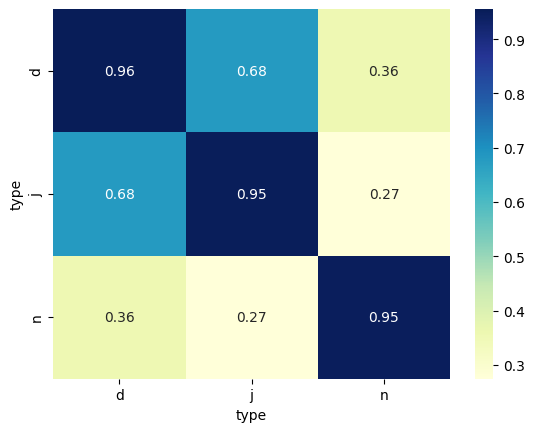

In [132]:
def magnitude(c):
    sum_squares = sum([x**2 for x in c])
    return math.sqrt(sum_squares)

def inner_product(x, y):
    return sum([x_i* y_i for x_i, y_i in zip(x, y)])

def cosine_similarity(x, y):
    return inner_product(x, y) / (magnitude(x) * magnitude(y))

def eucladian_distance(x, y):
    return math.sqrt(sum([(x_i - y_i)**2 for x_i, y_i in zip(x, y)]))

def make_correlation_matrix(avg_per_char=False):
    correlations = pd.DataFrame(index=char_vectors['type'], columns=char_vectors['type'])
    
    for i, row_i in char_vectors.iterrows():
        for j, row_j in char_vectors.iterrows():
            correlations.at[f"{row_i['type']}", f"{row_j['type']}"] = cosine_similarity(row_i['vector'], row_j['vector'])
                
    if avg_per_char:
        correlations = correlations.groupby(lambda x: x[0]).mean().groupby(lambda x: x[0], axis=1).mean()
        
    return correlations

correlation_matrix = make_correlation_matrix(avg_per_char=True)
sns.heatmap(correlation_matrix.astype(float), annot=True, cmap="YlGnBu")


From the heatmap can be seen the characters D and J are most similar, so thereby highest possibility to be confused

<Axes: xlabel='type', ylabel='type'>

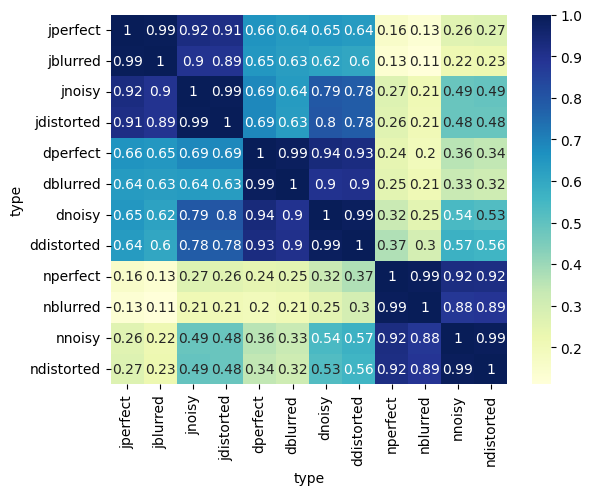

In [133]:
correlation_matrix = make_correlation_matrix()
sns.heatmap(correlation_matrix.astype(float), annot=True, cmap="YlGnBu")

In the complete correlation matrix above can be seen that the correlation between d and j is very high (around 0.8) for perfect, noisy, blurred and both. Whereby the noisy of j and d is the highest combination of 0.88 cosine similarity. This will complicate the detection.

In [134]:
grouped_chars = char_vectors.groupby('character')['vector']
NN1 = np.array([])

for char in chars:
    stck = np.stack(grouped_chars.get_group(char).to_numpy()).mean(axis=0)
    NN1 = np.append(NN1, stck)
    
NN1.resize((3, 25))

## Evaluation & Insights

[ 7.36752077 10.21558362  3.83494259]
The input vector is most likely a 'd' with a confidence of 47.70%


/var/folders/1h/x09k_pgn39d4j1gx2br0k3hm0000gn/T/ipykernel_59742/607397446.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=chars, y=result, palette="husl")


<Axes: >

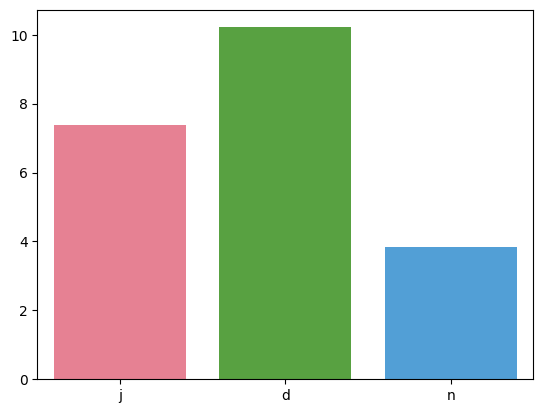

In [135]:
# Multiply NN1 with the input vector 
input_vector = make_noisy(make_blurred(d_perfect, blur_level=0.39), noise_level=0.34)
result = NN1 @ input_vector
print(result)
print(f"The input vector is most likely a '{chars[np.argmax(result)]}' with a confidence of {max(result)/sum(result)*100:.2f}%")

sns.barplot(x=chars, y=result, palette="husl")